---
# QC notebook for daymet mapping to onhm HRUs (GF_v11)

* Daymet provides a full mapping to the GF_v11.  This notebook check the sum of weights in the weights file and provides a plot of the raw data and mapped data for tmax as a qualitative confirmation of the mapping.

In [10]:
%matplotlib inline
import onhm
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt


---

Load paths and files on denali


---

In [11]:
from pathlib import Path

p_gm = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/dm_gf_v11')
p_gmr = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/daymet_v3_raw/north_america')
#I put the gf_v11 shapefile, only hru polys, in the following folder for processing so we'll use it for plotting
shpf_p = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/daymet_v3_raw/north_america')
# weights file used to map gridded gridmet to hrus is here
gm_wght_f = Path('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/git/onhm-fetcher-parser/') / 'daymet_weights_hru_v1_1e.csv'
print(f'the path {p_gm} exits: ', p_gm.exists())
print(f'the path {p_gmr} exits: ', p_gmr.exists())
print(f'the path {shpf_p} exits: ', shpf_p.exists())
print(f'the file {gm_wght_f} exits: ', gm_wght_f.exists())

the path /caldera/projects/usgs/water/wbeep/onhm_dev/climate/dm_gf_v11 exits:  True
the path /caldera/projects/usgs/water/wbeep/onhm_dev/climate/daymet_v3_raw/north_america exits:  True
the path /caldera/projects/usgs/water/wbeep/onhm_dev/climate/daymet_v3_raw/north_america exits:  True
the file /caldera/projects/usgs/water/wbeep/onhm_dev/climate/git/onhm-fetcher-parser/daymet_weights_hru_v1_1e.csv exits:  True


---

Read the GF_v11 shapefile (in geographic projection) into geopandas dataframe

---

In [12]:
shapefiles = shpf_p.glob("*2e*.shp")
gdf = pd.concat([
    gpd.read_file(shp)
    for shp in shapefiles
]).pipe(gpd.GeoDataFrame)
gdf.reset_index(drop=True, inplace=True)
# gdf.plot()
print(gdf)

               LAYER            GM_TYPE  OBJECTID  nhru_v11  hru_segme1  \
0       NHM\nhru_v11  Unknown Area Type         1     76127       40038   
1       NHM\nhru_v11  Unknown Area Type         2     76147       40038   
2       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
3       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
4       NHM\nhru_v11  Unknown Area Type         3     76170       40021   
...              ...                ...       ...       ...         ...   
139802  NHM\nhru_v11  Unknown Area Type    114954     57964       31028   
139803  NHM\nhru_v11  Unknown Area Type    114955     64080       28886   
139804  NHM\nhru_v11  Unknown Area Type    114956     64150       28866   
139805  NHM\nhru_v11  Unknown Area Type    114957     65633       31412   
139806  NHM\nhru_v11  Unknown Area Type    114958     18843       10081   

        Shape_Leng Shape_Area  nhm_id  hru_id_nat  Version  \
0        92601.509  188151328   76128

---

The next cells look at the weights file used to map gridded gridmet data to the HRU polygons.  Gridmet is available for conus only.  There are HRUs in GF_v11_2e that are either entirely outside the Gridmet footprint or are partially in the Gridmet footprint.  

---

In [13]:
pd_wght_f = pd.read_csv(gm_wght_f)
wghts_id = pd_wght_f.columns[1]
print(f'wght_id: {wghts_id}')
pd_wght_f.head()

wght_id: nhru_v11


,grid_ids,nhru_v11,w
0,17997007,76127,0.000885
1,17997011,76127,0.002030
2,17997010,76127,0.004571
3,17997009,76127,0.004744
4,17997008,76127,0.001928


---

Group the weights file by nhru_v11 (the hru id) and sum the weights

---

In [14]:
wght_sum = pd_wght_f.groupby(wghts_id).sum()
wght_sum.head()


,grid_ids,w
nhru_v11,,
1,188792356,1.0
2,224517370,1.0
3,44865028,1.0
4,17931597,1.0
5,62754650,1.0


In [15]:
wght_sum.index.values

array([     1,      2,      3, ..., 114956, 114957, 114958])

---

Check weights sum to 1

___

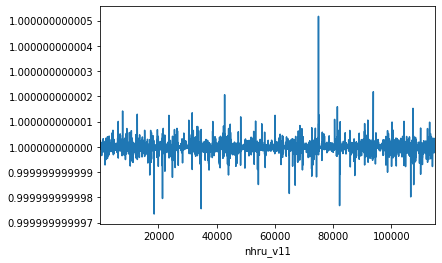

In [16]:
wght_sum.w.plot()
ax = plt.gca()
ax.ticklabel_format(useOffset=False)

---
# Plot example day from the Raw Gridmet data and the HRU-Mapped data

---

Pull the an example file for tmax from the raw gridmet data

In [17]:
ftmax = list(p_gmr.glob('*tmax_2018*.nc4'))
ftmax

[PosixPath('/caldera/projects/usgs/water/wbeep/onhm_dev/climate/daymet_v3_raw/north_america/daymet_v3_tmax_2018_na.nc4')]

In [18]:
dtmax = xr.open_dataset(ftmax[0])
dtmax

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 365, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
Dimensions without coordinates: nv
Data variables:
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    lambert_conformal_conic  int16 ...
    tmax                     (time, y, x) float32 ...
Attributes:
    start_year:        2018
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    Version_data:      Daymet Data Version 3.3

In [19]:
# import datetime as dt
# date = dt.datetime(year=int(1980),month=1,day=1)
# try:
#     lon = dprcp.lon.values
#     lat = dprcp.lat.values
#     ndata = np.zeros((1, (np.shape(lon)[0]) * (np.shape(lat)[0])))
#     ndata[0,:] = dprcp.daily_maximum_temperature  .sel(day=date).values.flatten()
# except KeyError:
#     print('error')

Open a hru-mapped dataset for tmax

In [20]:
ds = xr.open_dataset(p_gm / 'dm_climate_2018.nc' )
ds

<xarray.Dataset>
Dimensions:  (hruid: 114958, time: 365)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-31T12:00:00
  * hruid    (hruid) int32 1 2 3 4 5 6 ... 114954 114955 114956 114957 114958
Data variables:
    hru_lat  (hruid) float32 ...
    hru_lon  (hruid) float32 ...
    prcp     (time, hruid) float32 ...
    tmax     (time, hruid) float32 ...
    tmin     (time, hruid) float32 ...
    srad     (time, hruid) float32 ...
    swe      (time, hruid) float32 ...
    vp       (time, hruid) float32 ...
    dayl     (time, hruid) float32 ...
Attributes:
    Conventions:  CF-1.8
    featureType:  timeSeries
    history:

---
Grab values from hru-mapped dataset (ds) and map to the geodatafram (gdf) for plotting

---

In [21]:
gdf['tmax'] = 0.0
for index, row in gdf.iterrows():
    hind = row['nhru_v11']
    value = ds.tmax.values[0,hind-1]
    gdf.at[index,'tmax'] = ds.tmax.values[0,hind-1]
        

/home/rmcd/miniconda3/envs/ofp_env/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


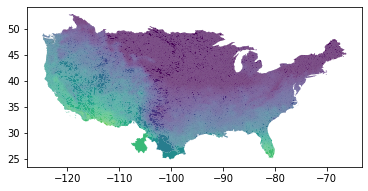

In [22]:
gdf.plot(column='tmax',vmin=-13, vmax=40)

I could not get xarray to plot with xrtmax.plot() so I plotted as below

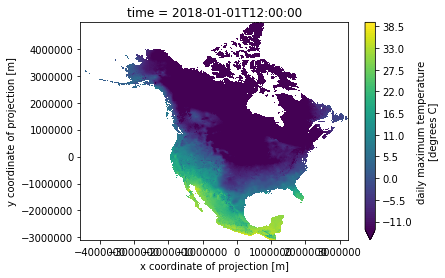

In [39]:
import datetime as dt
lvls = np.arange(-13, 40, 0.5)
date = dt.datetime(year=2018,month=1,day=1, hour=12)
xrtmax = dtmax.tmax.sel(time=date)
# p = xrtmax.plot(levels=lvls, cmap='viridis')
xrtmax.plot.imshow(x='x', y='y', levels=lvls, cmap='viridis')



In [37]:
xrtmax

<xarray.DataArray 'tmax' (y: 8075, x: 7814)>
[63098050 values with dtype=float32]
Coordinates:
  * x        (x) float32 -4560250.0 -4559250.0 ... 3251750.0 3252750.0
  * y        (y) float32 4984000.0 4983000.0 4982000.0 ... -3089000.0 -3090000.0
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
    time     datetime64[ns] 2018-01-01T12:00:00
Attributes:
    long_name:     daily maximum temperature
    units:         degrees C
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: maximum